In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import matplotlib.pyplot as plt





In [5]:
# Charger les données
X = pd.read_csv("data/X_final.csv")
y = pd.read_csv("data/y.csv").squeeze()  # transforme en série

print("Dimensions :", X.shape, y.shape)

Dimensions : (98053, 54) (98053,)


In [7]:
# Identifier les colonnes constantes
constant_cols = [col for col in X.columns if X[col].nunique() <= 1]

# Affichage des colonnes concernées
if constant_cols:
    print(f"{len(constant_cols)} variable(s) constante(s) détectée(s) :")
    print(constant_cols)
    
    # Suppression
    X = X.drop(columns=constant_cols)
    print(f"Nouveau nombre de variables : {X.shape[1]}")
else:
    print("Aucune variable constante détectée.")


Aucune variable constante détectée.


In [8]:
# diag_1, diag_2, diag_3 sont des codes ICD-9. On les regroupe en catégories médicales.

def map_icd9(code):
    if code.startswith('V') or code.startswith('E'):
        return 'Other'
    try:
        c = float(code)
    except:
        return 'Other'
    if 390 <= c <= 459 or c == 785: return 'Circulatory'
    if 460 <= c <= 519 or c == 786: return 'Respiratory'
    if 520 <= c <= 579 or c == 787: return 'Digestive'
    if str(int(c)).startswith('250'): return 'Diabetes'
    if 800 <= c <= 999: return 'Injury'
    if 710 <= c <= 739: return 'Musculoskeletal'
    if 580 <= c <= 629 or c == 788: return 'Genitourinary'
    if 140 <= c <= 239: return 'Neoplasms'
    return 'Other'

for col in ['diag_1', 'diag_2', 'diag_3']:
    X[col] = X[col].astype(str).apply(map_icd9)


In [9]:
# Identifie les colonnes non numériques (normalement diag_1, diag_2, diag_3)
non_numeric_cols = X.select_dtypes(exclude=['number']).columns
print("Colonnes non numériques :", list(non_numeric_cols))

# Encodage ordinal
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[non_numeric_cols] = encoder.fit_transform(X[non_numeric_cols])

# Vérification
print(X.dtypes.value_counts())


Colonnes non numériques : ['diag_1', 'diag_2', 'diag_3']
float64    29
int64      20
Name: count, dtype: int64


In [ ]:
# Nombre optimal de variables via validation croisée

model = LogisticRegression(max_iter=1000, random_state=42)

# Nombre de variables à tester
n_features = X.shape[1]
k_values = range(5, n_features + 1, 5)
cv_scores = []

# validation croisée reproductible
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Test de différents k via cross-validation
for k in k_values:
    selector = SelectKBest(score_func=mutual_info_classif, k=k)
    X_selected = selector.fit_transform(X, y)
    score = cross_val_score(model, X_selected, y, cv=cv, scoring='roc_auc').mean()
    cv_scores.append(score)

# Détermination du meilleur k (le plus petit atteignant le score max)
best_score = max(cv_scores)
best_k = k_values[np.where(cv_scores == np.max(cv_scores))[0][0]]  # premier k max

print(f"Nombre optimal de variables selon la cross-validation : {best_k}")

# Visualisation
plt.figure(figsize=(8,5))
plt.plot(k_values, cv_scores, marker='o', label='Score AUC')
plt.axvline(best_k, color='red', linestyle='--', label=f'k optimal = {best_k}')
plt.title("Performance selon le nombre de variables sélectionnées")
plt.xlabel("Nombre de variables (k)")
plt.ylabel("Score AUC (validation croisée)")
plt.legend()


plt.show()

In [10]:
# Sélection selon l'information mutuelle
selector = SelectKBest(score_func=mutual_info_classif, k='all')
X_selected = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()]
scores = selector.scores_[selector.get_support()]

# Affichage
feat_scores = pd.DataFrame({'Variable': selected_features, 'Score': scores})
feat_scores.sort_values('Score', ascending=False, inplace=True)
print(feat_scores)


                    Variable     Score
9           number_inpatient  0.016223
12            race_Caucasian  0.015174
1   discharge_disposition_id  0.012748
15               gender_Male  0.011559
2        admission_source_id  0.005370
10          number_diagnoses  0.005189
0          admission_type_id  0.005166
7          number_outpatient  0.004869
8           number_emergency  0.004818
28                    diag_3  0.004217
44                   insulin  0.003506
3           time_in_hospital  0.003435
27                    diag_2  0.003424
5             num_procedures  0.003407
26                    diag_1  0.002996
23               age_[70-80)  0.002856
21               age_[50-60)  0.002816
22               age_[60-70)  0.002492
34             acetohexamide  0.001665
29                 metformin  0.001604
6            num_medications  0.001200
37               tolbutamide  0.001159
48    metformin-pioglitazone  0.000799
13             race_Hispanic  0.000732
11                race_As

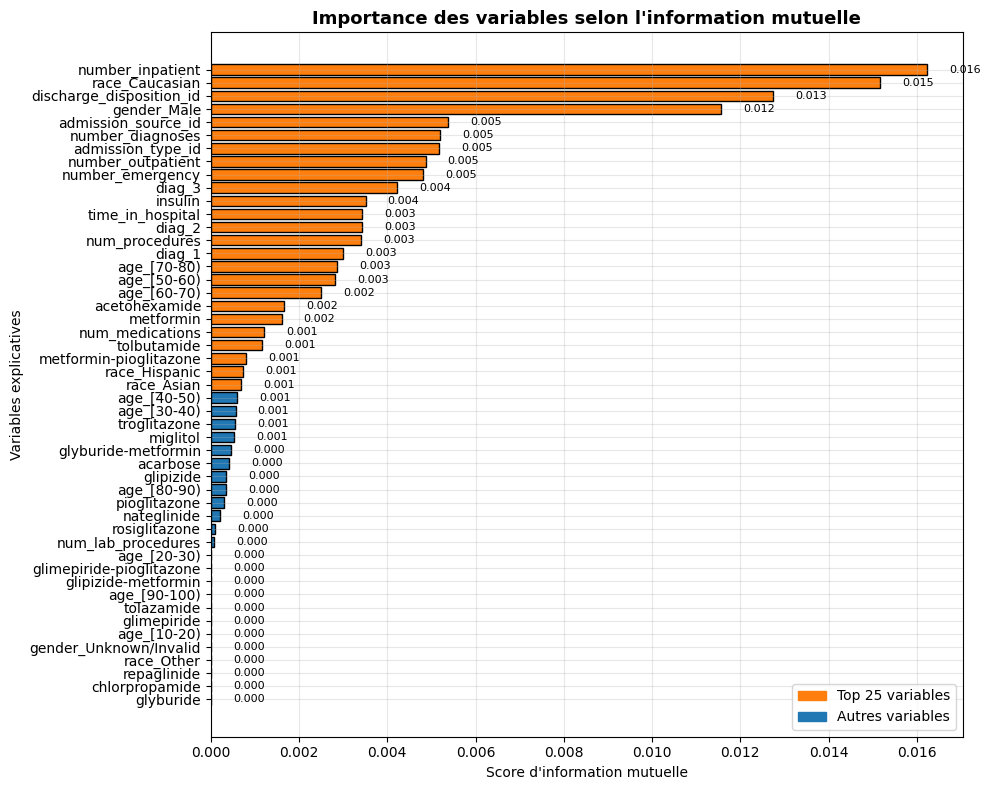

 Visualisation terminée : Top 25 variables en orange, autres en bleu.


In [ ]:
# Tri des variables par score décroissant
feat_scores_sorted = feat_scores.sort_values('Score', ascending=False).reset_index(drop=True)

# TOP 25 variables
top_k = 25
feat_scores_sorted['Couleur'] = [
    '#ff7f0e' if i < top_k else '#1f77b4'
    for i in range(len(feat_scores_sorted))
]

# Visualisation 
plt.figure(figsize=(10, 8))
plt.barh(
    feat_scores_sorted['Variable'],
    feat_scores_sorted['Score'],
    color=feat_scores_sorted['Couleur'],
    edgecolor='black'
)

plt.title("Importance des variables selon l'information mutuelle", fontsize=13, weight='bold')
plt.xlabel("Score d'information mutuelle")
plt.ylabel("Variables explicatives")
plt.gca().invert_yaxis()

# Valeurs sur les barres 
for i, v in enumerate(feat_scores_sorted['Score']):
    plt.text(v + 0.0005, i, f"{v:.3f}", va='center', fontsize=8)

# Légende simple
plt.legend(
    handles=[
        plt.Rectangle((0, 0), 1, 1, color='#ff7f0e', label='Top 25 variables'),
        plt.Rectangle((0, 0), 1, 1, color='#1f77b4', label='Autres variables')
    ],
    loc='best'
)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


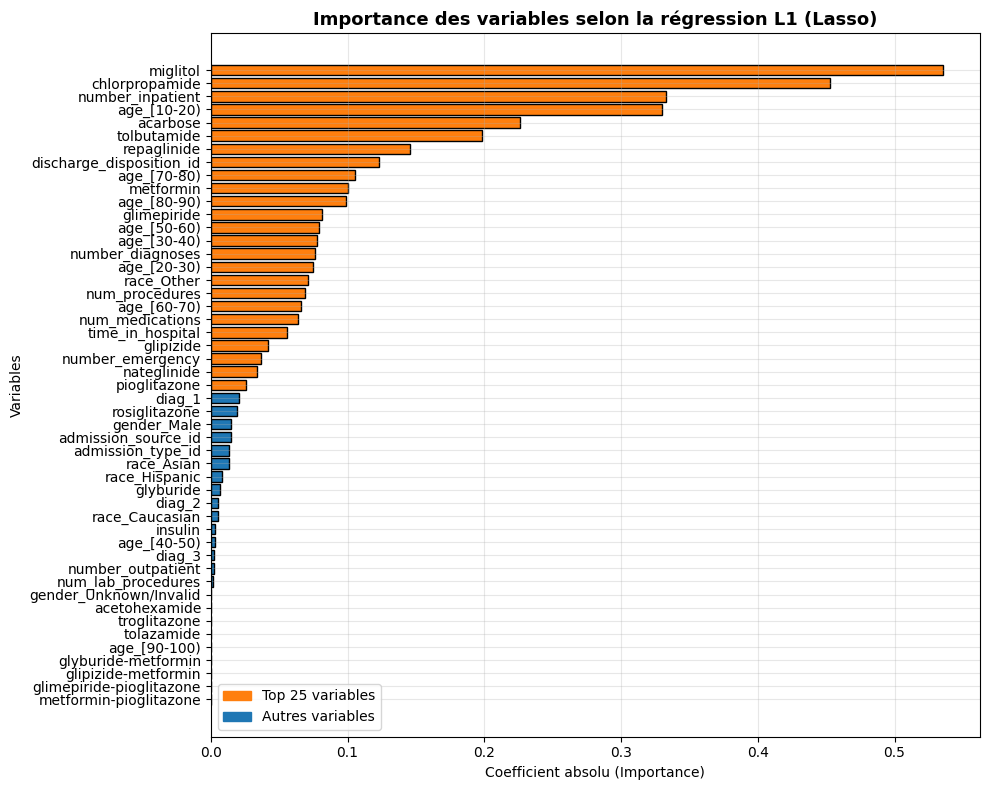

✅ Visualisation terminée : Top 25 variables en orange, autres en bleu.


In [ ]:
# Sélection de variables par régression logistique L1 (Lasso)

# Entraînement du modèle régularisé L1
log_reg = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    max_iter=1000,
    random_state=42
)
log_reg.fit(X, y)  # attention X standardisation

# Extraction de l'importance absolue des coefficients
importance = np.abs(log_reg.coef_[0])

# Création du DataFrame trié
lasso_feat = (
    pd.DataFrame({'Variable': X.columns, 'Importance': importance})
    .sort_values('Importance', ascending=False)
    .reset_index(drop=True)
)

# TOP 25 variables
top_k = 25
lasso_feat['Couleur'] = [
    '#ff7f0e' if i < top_k else '#1f77b4'
    for i in range(len(lasso_feat))
]

# Visualisation
plt.figure(figsize=(10, 8))
plt.barh(
    lasso_feat['Variable'],
    lasso_feat['Importance'],
    color=lasso_feat['Couleur'],
    edgecolor='black'
)

plt.title("Importance des variables selon la régression L1 (Lasso)", fontsize=13, weight='bold')
plt.xlabel("Coefficient absolu (Importance)")
plt.ylabel("Variables")

plt.gca().invert_yaxis()

plt.legend(
    handles=[
        plt.Rectangle((0, 0), 1, 1, color='#ff7f0e', label='Top 25 variables'),
        plt.Rectangle((0, 0), 1, 1, color='#1f77b4', label='Autres variables')
    ],
    loc='best'
)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

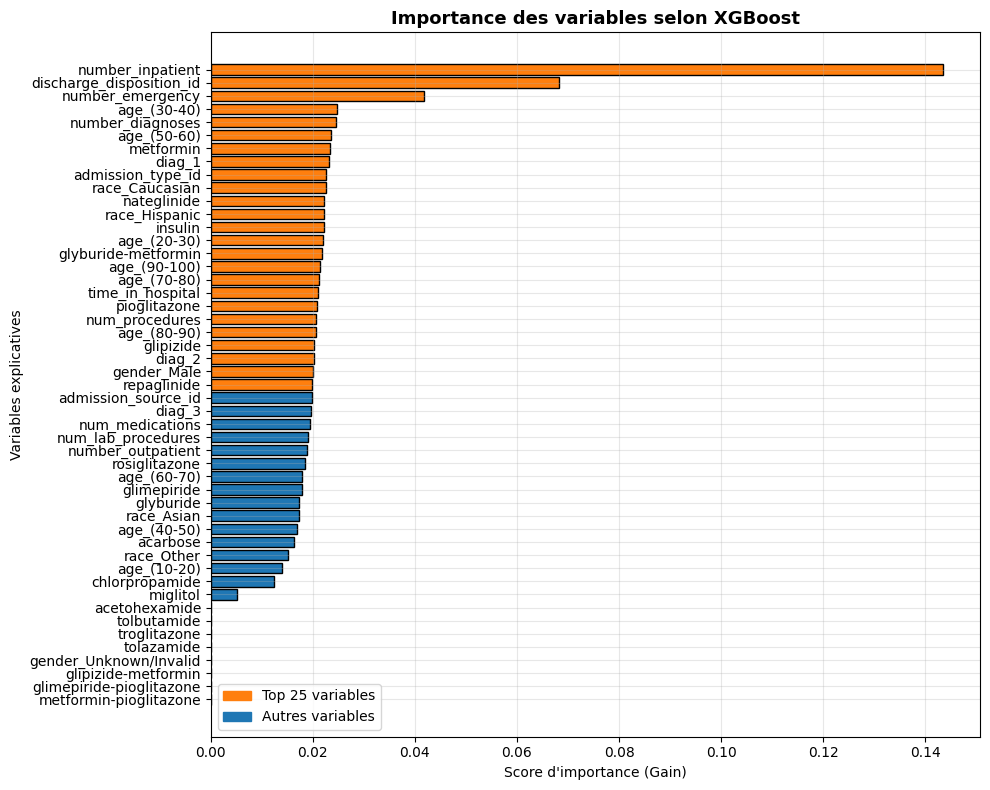

In [ ]:
# Importance des variables selon XGBoost

# Entraînement du modèle XGBoost
xgb = XGBClassifier(
    random_state=42,
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss'
)



# Nettoyage des noms de colonnes (sécurité)
X.columns = X.columns.astype(str)
X.columns = (
    X.columns.str.replace('[', '(', regex=False)
              .str.replace(']', ')', regex=False)
              .str.replace('<', 'inf', regex=False)
              .str.replace('>', 'sup', regex=False)
)

xgb.fit(X, y)

#  Importance des variables 
xgb_importance = pd.Series(xgb.feature_importances_, index=X.columns)
xgb_importance = xgb_importance.sort_values(ascending=False).reset_index()
xgb_importance.columns = ['Variable', 'Importance']

# Top 25
top_k = 25
xgb_importance['Couleur'] = [
    '#ff7f0e' if i < top_k else '#1f77b4' for i in range(len(xgb_importance))
]

# Visualisation
plt.figure(figsize=(10, 8))
plt.barh(
    xgb_importance['Variable'],
    xgb_importance['Importance'],
    color=xgb_importance['Couleur'],
    edgecolor='black'
)
plt.gca().invert_yaxis()

plt.title("Importance des variables selon XGBoost", fontsize=13, weight='bold')
plt.xlabel("Score d'importance (Gain)")
plt.ylabel("Variables explicatives")

plt.legend(
    handles=[
        plt.Rectangle((0, 0), 1, 1, color='#ff7f0e', label='Top 25 variables'),
        plt.Rectangle((0, 0), 1, 1, color='#1f77b4', label='Autres variables')
    ],
    loc='best'
)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


✅ Variables finales retenues (25) :
['number_inpatient', 'discharge_disposition_id', 'race_Caucasian', 'gender_Male', 'miglitol', 'chlorpropamide', 'number_emergency', 'number_diagnoses', 'age_[10-20)', 'admission_type_id', 'admission_source_id', 'acarbose', 'num_procedures', 'number_outpatient', 'time_in_hospital', 'diag_3', 'metformin', 'tolbutamide', 'insulin', 'diag_1', 'diag_2', 'age_[70-80)', 'repaglinide', 'age_[50-60)', 'num_medications']

💾 Fichiers sauvegardés :
 - data/merged_feature_scores.csv
 - data/X_final_selected.csv


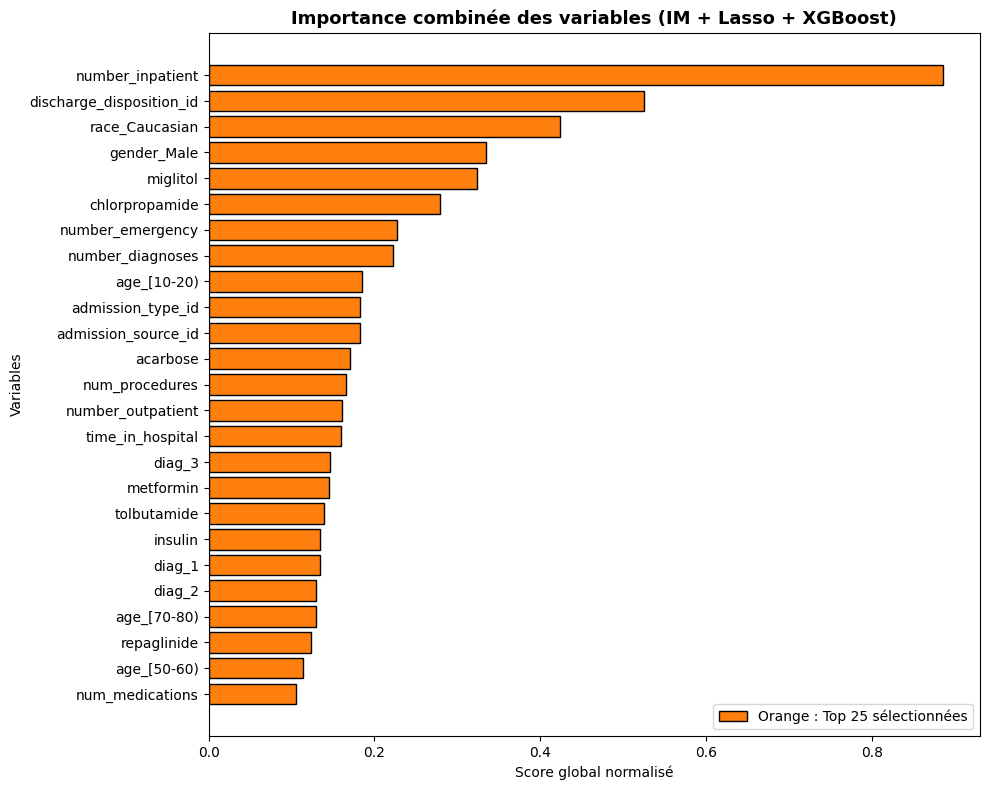

In [ ]:
# selection finale via fusion des 3 méthodes


# Copie et nettoyage des trois DataFrames
def clean_df(df, var_col, score_col, new_name):
    df = df.copy()
    df = df[[var_col, score_col]].rename(columns={var_col: 'Variable', score_col: new_name})
    # Conversion en float propre
    df[new_name] = pd.to_numeric(df[new_name], errors='coerce').astype(float)
    # Supprime les doublons
    df = df.drop_duplicates(subset=['Variable'])
    # Supprime les index ou listes dans Variable
    df['Variable'] = df['Variable'].astype(str)
    return df

feat_scores_clean = clean_df(feat_scores, 'Variable', 'Score', 'IM_Score')
lasso_feat_clean  = clean_df(lasso_feat, 'Variable', 'Importance', 'Lasso_Score')
xgb_importance_clean = clean_df(xgb_importance, 'Variable', 'Importance', 'XGB_Score')

# Normalisation
scaler = MinMaxScaler()
for df, col in [(feat_scores_clean, 'IM_Score'),
                (lasso_feat_clean, 'Lasso_Score'),
                (xgb_importance_clean, 'XGB_Score')]:
    df[col] = scaler.fit_transform(df[[col]])

# Fusion sécurisée avec reduce (évite les DataFrames 2D) 
from functools import reduce
dfs = [feat_scores_clean, lasso_feat_clean, xgb_importance_clean]

merged = reduce(
    lambda left, right: pd.merge(left, right, on='Variable', how='outer'),
    dfs
).fillna(0)

# Score global pondéré
merged['Score_Global'] = (
    0.4 * merged['IM_Score'] +
    0.3 * merged['Lasso_Score'] +
    0.3 * merged['XGB_Score']
)

# Tri et sélection
merged = merged.sort_values('Score_Global', ascending=False).reset_index(drop=True)

top_k = 25
final_vars = merged.head(top_k)['Variable'].tolist()

print(f"Variables finales retenues ({top_k}) :")
print(final_vars)

# Export
merged.to_csv("data/merged_feature_scores.csv", index=False)

present = [v for v in final_vars if v in X.columns]
X_final = X[present]
X_final.to_csv("data/X_final_selected.csv", index=False)


# Visualisation 

plt.figure(figsize=(10, 8))
top_n = merged.head(25)
colors = ['#ff7f0e' if v in final_vars else '#1f77b4' for v in top_n['Variable']]
plt.barh(top_n['Variable'], top_n['Score_Global'], color=colors, edgecolor='black')
plt.gca().invert_yaxis()
plt.title("Importance combinée des variables (IM + Lasso + XGBoost)", fontsize=13, weight='bold')
plt.xlabel("Score global normalisé")
plt.ylabel("Variables")
plt.legend(['Orange : Top 25 sélectionnées', 'Bleu : Autres'])
plt.tight_layout()
plt.show()
